<a href="https://colab.research.google.com/github/arjunahiran/solent-module-COM727-chatbot/blob/main/LungCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Import Necessary Libraries***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import PIL
from google.colab import files
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.utils import image_dataset_from_directory, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential, load_model
#from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
image = PIL.Image.open("/content/gdrive/MyDrive/COM726/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/ad14.png")


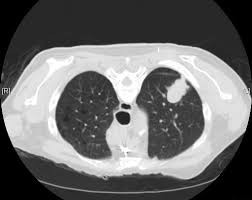

In [ ]:
image

In [3]:
learning_rate = 0.0001
input_size = (224,224)
batch_size=32
monitor="val_loss"
list_model = ["ResNet101", "ResNet152", "VGG16", "EfficientNetB6", "EfficientNetB7"]
list_model_acc = []
list_model_loss = []

In [ ]:
def plot_loss_acc(history) :
    """
    Plots line plots of model accuracy and model loss.

    Args:
        history (object): The history of the model.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['train', 'val'], loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
def eval_test(model,checkPoint_path):
    """
    Prints classification report and plots confusion matrix heatmap on the test data
    Stores accuracy and loss of models

    Args:
        model (object) : The model to be evaluated.
        checkPoint_path (str) : The path of the checkpoint
    """
    model.load_weights(checkPoint_path)
    test_evaluate = model.evaluate(test_data)
    list_model_acc.append(test_evaluate[1])
    list_model_loss.append(test_evaluate[0])
    y_pred = model.predict(test_data)
    y_pred = np.argmax(y_pred, axis=1)
    print(classification_report(y_pred,test_data.classes))
    cm = confusion_matrix(y_pred,test_data.classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    ax = disp.plot(cmap='Blues').ax_
    ax.set_title("Confusion matrix in test data")
    plt.show()



In [ ]:
early_stop = EarlyStopping(
    monitor=monitor,
    patience=10
)

**LOAD DATA FROM DIRECTORY**

In [4]:
train_data = ImageDataGenerator().flow_from_directory(
    '/content/gdrive/MyDrive/COM726/train',
    shuffle=True,
    batch_size=batch_size,
    target_size = input_size
)

Found 36 images belonging to 4 classes.


In [5]:
valid_data = ImageDataGenerator().flow_from_directory(
    "/content/gdrive/MyDrive/COM726/valid",
    shuffle=False,
    batch_size = batch_size,
    target_size = input_size
)

Found 40 images belonging to 4 classes.


In [6]:
test_data = ImageDataGenerator().flow_from_directory(
    "/content/gdrive/MyDrive/COM726/test",
    shuffle=False,
    batch_size = batch_size,
    target_size = input_size
)

Found 36 images belonging to 4 classes.


**EDA on Lung cancer images**

>



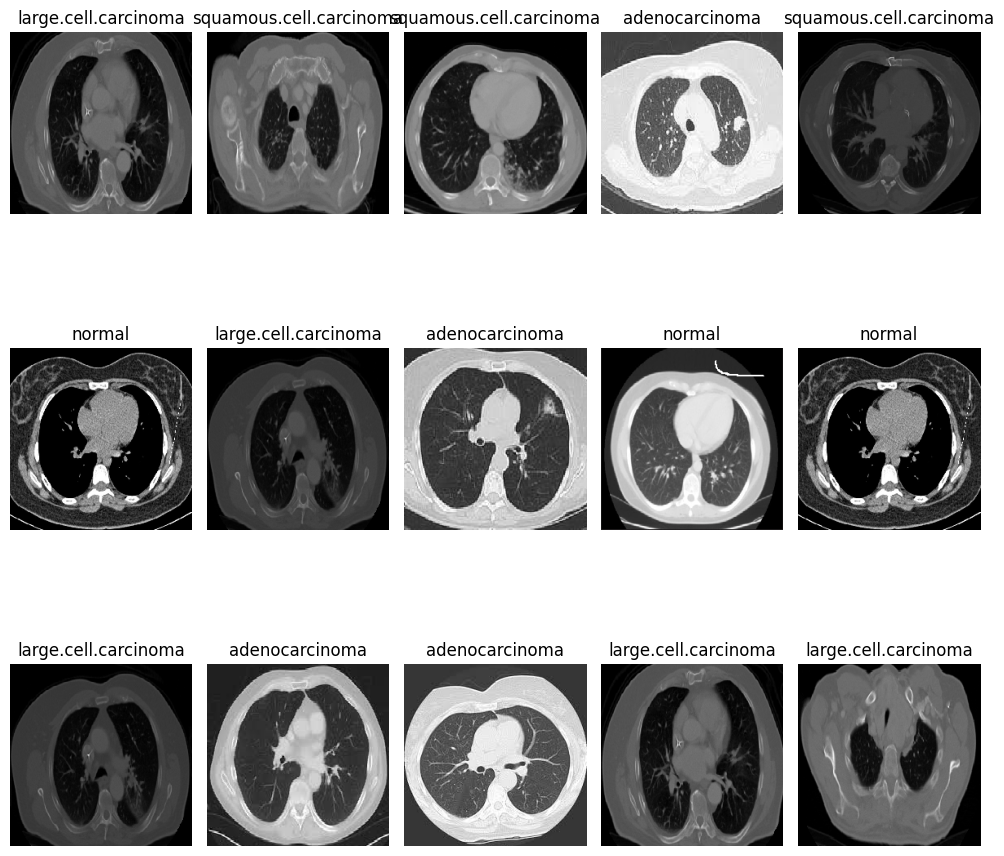

In [ ]:
class_names = list(test_data.class_indices.keys())
plt.figure(figsize=(10,10))
for i,(images, labels) in enumerate(train_data):
    if i ==15:
        break
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(3,5, i+1)
    plt.imshow(images[0].astype("uint8"))
    class_index = list(labels[0]).index(1)
    class_name = class_names[class_index]
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
ROOT_DIR="/content/gdrive/MyDrive/COM726"
number_of_images = {}

# Iterate over the train, valid, and test directories
for subset in ["train", "valid", "test"]:
    subset_dir = os.path.join(ROOT_DIR, subset)
    number_of_images[subset] = {}

    # Iterate over each class directory within the subset directory
    for class_dir in os.listdir(subset_dir):
        class_path = os.path.join(subset_dir, class_dir)
        if os.path.isdir(class_path):  # Check if it's a directory
            number_of_images[subset][class_dir] = len(os.listdir(class_path))

# Print the counts
for subset, classes in number_of_images.items():
    print(f"{subset.capitalize()} data:")
    for class_name, count in classes.items():
        print(f"  {class_name}: {count} images")

Train data:
  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 9 images
  large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 9 images
  normal: 9 images
  squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 9 images
Valid data:
  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 10 images
  large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 10 images
  normal: 10 images
  squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 10 images
Test data:
  adenocarcinoma: 9 images
  large.cell.carcinoma: 9 images
  normal: 9 images
  squamous.cell.carcinoma: 9 images


#Model Build

In [9]:
from keras.layers import Conv2D, AvgPool2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array
import keras

In [10]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3),activation='relu', input_shape=(224,224,3)))

model.add(Conv2D(filters=36, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate= 0.25))

model.add(Flatten())
model.add(Dense(units=64, activation= 'relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=64,activation= 'sigmoid'))

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 conv2d_15 (Conv2D)          (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 110, 110, 36)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 128)      

In [11]:
model.compile(optimizer='adam', loss= keras.losses.binary_crossentropy, metrics= ['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the correct paths
train_dir = '/content/gdrive/MyDrive/COM726/train'
valid_dir = '/content/gdrive/MyDrive/COM726/valid'
test_dir = '/content/gdrive/MyDrive/COM726/test'

# ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_data = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')



#Split Data
70% for Training
15% for validation
15% for Testing

In [8]:
import random
import shutil

# Define paths to your directories
train_dir = '/content/gdrive/MyDrive/COM726/train'
valid_dir = '/content/gdrive/MyDrive/COM726/valid'
test_dir = '/content/gdrive/MyDrive/COM726/test'

# Define percentages for each set
train_percentage = 0.7
valid_percentage = 0.15
test_percentage = 0.15

# Function to split data
def split_data(source_dir, train_percentage, valid_percentage, test_percentage):
    # Iterate through each class directory
    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if os.path.isdir(class_dir):
            files = os.listdir(class_dir)
            random.shuffle(files)  # Shuffle the files
            num_files = len(files)

            # Calculate split indices
            train_end = int(train_percentage * num_files)
            valid_end = int((train_percentage + valid_percentage) * num_files)

            # Split files into train, valid, test sets
            train_files = files[:train_end]
            valid_files = files[train_end:valid_end]
            test_files = files[valid_end:]

            # Create destination directories if they don't exist
            train_dest = os.path.join(train_dir, class_name)
            valid_dest = os.path.join(valid_dir, class_name)
            test_dest = os.path.join(test_dir, class_name)

            os.makedirs(train_dest, exist_ok=True)
            os.makedirs(valid_dest, exist_ok=True)
            os.makedirs(test_dest, exist_ok=True)

            # Move files to destination directories
            for file in train_files:
                shutil.move(os.path.join(class_dir, file), os.path.join(train_dest, file))
            for file in valid_files:
                shutil.move(os.path.join(class_dir, file), os.path.join(valid_dest, file))
            for file in test_files:
                shutil.move(os.path.join(class_dir, file), os.path.join(test_dest, file))

# Split data for train, valid, and test directories
split_data(train_dir, train_percentage, valid_percentage, test_percentage)
split_data(valid_dir, train_percentage, valid_percentage, test_percentage)
split_data(test_dir, train_percentage, valid_percentage, test_percentage)

print("Data split completed successfully.")

NameError: name 'os' is not defined

# Check for Missing or Corrupted Files

In [ ]:
#Check for Missing or Corrupted Files
import os
from PIL import Image

def check_for_corrupted_images(directory):
    corrupted_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Verify that it is an image
                except (IOError, SyntaxError) as e:
                    print(f"Corrupted file found: {file_path}")
                    corrupted_files.append(file_path)
    return corrupted_files

train_data = '/content/gdrive/MyDrive/COM726/train'
valid_data = '/content/gdrive/MyDrive/COM726/valid'
test_data = '/content/gdrive/MyDrive/COM726/test'

corrupted_train = check_for_corrupted_images(train_data)
corrupted_valid = check_for_corrupted_images(valid_data)
corrupted_test = check_for_corrupted_images(test_data)


**Check Image Quality**

In [ ]:
def is_low_contrast_color(image, threshold=0.05):
    # Apply is_low_contrast to each channel separately
    for i in range(image.shape[-1]):  # Assuming image is in (height, width, channels) format
        if exposure.is_low_contrast(image[..., i], fraction_threshold=threshold):
            return True
    return False

def check_image_quality(generator, num_batches=1):
    low_quality_images = []
    for _ in range(num_batches):
        #images, _ = next(generator)
        for img in images:
            img = np.array(img).astype(np.uint8)
            if img.ndim == 3:  # Check if image has color channels
                if is_low_contrast_color(img):
                    low_quality_images.append(img)
            else:
                if exposure.is_low_contrast(img):
                    low_quality_images.append(img)
    return low_quality_images

# Assuming train_data, valid_data, and test_data are defined and are generators

# Check low quality images
low_quality_train = check_image_quality(train_data)
low_quality_valid = check_image_quality(valid_data)
low_quality_test = check_image_quality(test_data)

print(f"Low quality images in training set: {len(low_quality_train)}")
print(f"Low quality images in validation set: {len(low_quality_valid)}")
print(f"Low quality images in test set: {len(low_quality_test)}")

# Visualize low quality images if any
def visualize_low_quality_images(images, title):
    plt.figure(figsize=(15, 15))
    num_images = len(images)
    for i in range(min(num_images, 5)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i])
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_low_quality_images(low_quality_train, 'Low Quality - Train')
visualize_low_quality_images(low_quality_valid, 'Low Quality - Valid')
visualize_low_quality_images(low_quality_test, 'Low Quality - Test')

Low quality images in training set: 0
Low quality images in validation set: 0
Low quality images in test set: 0


<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

In [ ]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])


# Get Predictions
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()


# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())

    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

# **Data Augmentation**

Found 36 images belonging to 4 classes.


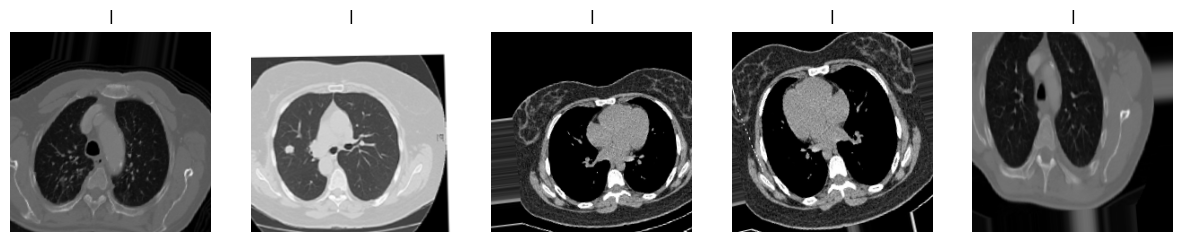

In [ ]:
# Example of augmentation (if you have any)
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualize the effect of augmentation
def visualize_augmentation(generator, class_name, num_samples=5):
    #class_index = generator.class_indices[class_name]
    for images, labels in generator:
        if np.argmax(labels[0]) == class_index:
            plt.figure(figsize=(15, 15))
            for i in range(num_samples):
                augmented_image = next(generator)[0][0]
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(augmented_image)
                plt.title(class_name)
                plt.axis('off')
            plt.show()
            break

visualize_augmentation(augmented_datagen.flow_from_directory(train_data, target_size=input_size, batch_size=1, class_mode='categorical'), class_name[0])


In [ ]:
# Define the size of the input images
img_size = (224, 224)

# Specify the number of color channels in the images (3 for RGB)
channels = 3

# Specify the color representation ('rgb' for red, green, blue)
color = 'rgb'

# Define the shape of the input images based on size, channels, and color representation
img_shape = (img_size[0], img_size[1], channels)

# Specify the batch size for training
batch_size = 32

# Get the length of the test DataFrame
ts_length = len(test_data)

# Determine an optimal test batch size that evenly divides the length of the test DataFrame
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

# Calculate the number of steps needed to cover the entire test dataset
test_steps = ts_length // test_batch_size

# Define a function 'scalar' that takes an image as input (placeholder, no implementation provided)
def scalar(img):
    return img

In [ ]:
tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                            horizontal_flip= True)

# Create an ImageDataGenerator for training with specified preprocessing and augmentation settings
tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)

# Create an ImageDataGenerator for testing with specified preprocessing settings
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

# Generate a flow from DataFrame for training data
train_gen = ts_gen.flow_from_directory(
    train_data,
    x_col='',
    y_col='',
    target_size=img_size,
    class_mode='categorical',
    color_mode=color,
    shuffle=True,
    batch_size=batch_size
)

# Generate a flow from DataFrame for validation data
valid_gen = ts_gen.flow_from_directory(
    valid_data,
    x_col='',
    y_col='',
    target_size=img_size,
    class_mode='categorical',
    color_mode=color,
    shuffle=True,
    batch_size=batch_size
)

# Generate a flow from DataFrame for test data
test_gen = ts_gen.flow_from_directory(
    test_data,
    x_col='',
    y_col='',
    target_size=img_size,
    class_mode='categorical',
    color_mode=color,
    shuffle=False,
    batch_size=test_batch_size
)

TypeError: ImageDataGenerator.flow_from_directory() got an unexpected keyword argument 'x_col'